<a href="https://colab.research.google.com/github/digwit678/Can-Language-Models-Follow-Discussions/blob/main/probing_sw5_nlargest_30_to_100_discussions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Utility Functions (often used)

In [ ]:
#!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 13.0 MB/s eta 0:00:00


In [ ]:
base_path_gdrive = "/content/drive/MyDrive/Can Language Models Follow Discussions?/"

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [66]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
#import igraph as ig
import yaml
import os
import re
from random import seed
from tqdm import tqdm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed(42)

In [ ]:
def save_final_files_to_drive(probing_example_nr, df, num_inputs, subsample=False, additional_info="", control_task_type="NONE", num_labels=2, num_probe_folds=1, probe_task_type="", probes_samples_path="sample_probes"):
    """
    Save the final probing files to Google Drive.

    Parameters:
    - probing_example_nr: The probing example number used in the folder path.
    - df: The DataFrame to save.
    - num_inputs: Number of input sentences (1 for single sentence, 2 for two sentences).
    - subsample: Boolean flag to indicate if it's a subsample or full data (default: False).
    - additional_info:  is added to the end of the probe name if specified
    - control_task_type: The type of control task (default: "NONE").
    - num_labels: Number of labels (default: 2).
    - num_probe_folds: Number of probing folds (default: 1).
    - probe_task_type: The task type of the probe (default: "SENTENCE").
    - probes_samples_path: Relative path to the probe (default: "sample_probes").
    """

    # Determine folder based on subsample or full
    folder_type = "subsample" if subsample else "full"

    # Set the base path
    base_path = f"/content/drive/MyDrive/Can Language Models Follow Discussions?/{probing_example_nr}/final probing files/{folder_type}/{(additional_info if additional_info != '' else '')}"

    # Create folder if not exists
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Determine the config file name
    config_name = "config"
    if num_inputs == 2:
        config_name += "-bi"
    if subsample:
        config_name += "-rand"
    config_name += "-none.yaml"

    # Create YAML config content
    config_content = {
        'control_task_type': control_task_type,
        'num_inputs': num_inputs,
        'num_labels': num_labels,
        'num_probe_folds': num_probe_folds,
        'probe_name': f"probe-{('single' if num_inputs == 1 else 'two')}_sentence_probing_task_{(additional_info if additional_info != '' else '')}_{probing_example_nr}",
        'probe_task_type': ("SENTENCE" if num_inputs == 1 else "SENTENCE_PAIR_BI") if probe_task_type =="" else probe_task_type,
        'probes_samples_path': f"{probes_samples_path}/{('single' if num_inputs == 1 else 'two')}_sentence_probing_task"
    }

    # Save YAML file
    with open(base_path + config_name, 'w') as file:
        yaml.safe_dump(config_content, file, default_flow_style=False)

    # Save DataFrame as CSV
    df.to_csv(base_path + "folds.csv", index=True)

    print(f"Files saved at {base_path}")


In [ ]:
def load(path_end, file_type="csv"):
  """
  - path_end: provide number + file name
  - file_type: "p" for pickle or "" for csv

  """
  base_path_gdrive = "/content/drive/MyDrive/Can Language Models Follow Discussions?/"
  if file_type == "p":
    with open (base_path_gdrive + path_end + "." + file_type , 'rb') as f:
        file_out = all_node_info = pickle.load(f)
  else:
        file_out = pd.read_csv(base_path_gdrive + path_end + "." + file_type, index_col=[0])
  return file_out

In [ ]:
def save(df, name, probing_task_nr, input_type = "df", output_type = "csv"):
  base_path_gdrive= "/content/drive/MyDrive/Can Language Models Follow Discussions?/"
  full_file_path = base_path_gdrive + f"{probing_task_nr}/{name}.{output_type}"
  if input_type == "df":
    if output_type == "csv":
          df.to_csv(full_file_path)
          print(f"{name}.{output_type} saved to {base_path_gdrive}{probing_task_nr}/")
    if output_type == "pkl":
          df.to_pickle(full_file_path)
  if input_type == "dc":
    if output_type == "pkl":
        with open(full_file_path, 'wb') as f:
          pickle.dump(full_file_path, f)
  print(f'File saved as {full_file_path}')

In [ ]:
def save_dataframe_to_drive(probing_example_nr, df, file_type='e', task_name='task'):
    # Set the base path
    base_path = f"/content/drive/MyDrive/Can Language Models Follow Discussions?/{probing_example_nr}/final probing files/"

    # Create the filename
    filename = f"{probing_example_nr}_{task_name}_data"

    # Full file path
    if file_type == 'p':
        full_file_path = f"{base_path}{filename}.pkl"
        df.to_pickle(full_file_path)
    else:
        full_file_path = f"{base_path}{filename}.xlsx"
        df.to_excel(full_file_path, index=False)

    print(f"File saved at {full_file_path}")

# Example usage:
# save_dataframe_to_drive(1, df, file_type='e', task_name='my_task')


In [ ]:
def print_first_n_entries(dictionary, n, max_inner_items=5):
    """
    Print the first 'n' entries of a nested dictionary, showing only the first 'max_inner_items' key-value pairs of the inner dictionary at each depth level.

    Args:
        dictionary (dict): The nested dictionary to print.
        n (int): The number of entries to print.
        max_inner_items (int): The maximum number of key-value pairs to print from the inner dictionary at each depth level.

    Returns:
        None
    """
    def print_nested_dict(d, depth):
        if depth >= max_depth:
            return

        for key, value in d.items():
            if len(entries) >= n:
                return

            entries.append((key, value))
            print(f"Entry {len(entries)}:")
            print(f"Key: {key}")
            print("Value:")

            if isinstance(value, dict):
                sub_dict = {k: value[k] for k in list(value)[:max_inner_items]}
                print_nested_dict(sub_dict, depth + 1)
            else:
                print(f"  {value}\n")

    max_depth = max_inner_items
    entries = []

    print_nested_dict(dictionary, 0)



In [ ]:
def create_general_dataframe(claim_pairs, context, topics, org_labels, slabels, identifiers):
    """
    Creates a DataFrame for probing tasks with the given parameters.

    Parameters:
        claim_pairs (list of tuple): List of tuples where each tuple contains two claims to compare.
        context (list of str): List of context for each claim pair if specified else left empty/NaN.
        topics (list of str): Base Claim Text / Discussion Topic
        org_labels (list of str): List of original labels as string (e.g. "Consecutive", "Non-Consecutive", etc.).
        labels (list of int): List of integer labels (1 for "Consecutive", 0 for "Non-Consecutive").
        identifiers (list of int): List of unique identifiers for each claim pair.

    Returns:
        DataFrame: A DataFrame containing the data in the specified format.
    """

    df = pd.DataFrame({
        'inputs': claim_pairs,
        'context': context,
        'topic': topics,
        'org_label': org_labels,
        'id': identifiers,
        'string_label': labels,
        'label': labels  # assuming that string_label and label are the same
    })

    # Split
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, dev = train_test_split(train, test_size=0.25, random_state=42)

    # Assign set
    train['set-0'] = 'train'
    dev['set-0'] = 'dev'
    test['set-0'] = 'test'

    # Combine
    final_df = pd.concat([train, dev, test])

    return final_df


In [ ]:
from urllib.parse import urlparse
def preprocess_text_with_stopwords(text, stop_words):
    """
    Removes stop words, punctuation, URLs, and converts to lowercase.
    """
    # Extract meaningful parts from URLs (leave away Scheme, Subdomain, Second-level Domain and Top-level Domain)
    text = re.sub(r'\[([^\]]+)]\((https?://[^\s]+)\)',
                  lambda x: ' '.join(urlparse(x.group(2)).path.strip('/').split('/')[-1].split('.')[:-1]),
                  text)

    # Convert to lowercase
    text = text.lower()

    # Tokenize and remove stop words
    text = ' '.join([word for word in word_tokenize(text) if word.isalnum() and word not in stop_words])

    return text


"""
v1 used for BOW, Doc2Vec
def preprocess_text_with_stopwords(text, stop_words):

    Removes stop words, punctuation, and converts to lowercase.

    text = text.lower()
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'[^\w\s]', '', text)
    return text
    """

"""
v1 used for BOW, Doc2Vec

# List of common stop words in English
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",
              "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",
              "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",
              "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",
              "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",
              "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",
              "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
              "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
              "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

"""

'\nv1 used for BOW, Doc2Vec\n\n# List of common stop words in English\nstop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves",\n              "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their",\n              "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was",\n              "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and",\n              "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between",\n              "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off",\n              "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",\n              

In [ ]:
node_df = load("2/node_attributes_v4")

In [ ]:
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized Stance Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


In [ ]:
# for diagrams / displaying
node_df['Shortened_Base_Claim_Text'] = node_df['Base_Claim_Text'].str.slice(0, 50) + "..."

# Counting the number of claims per discussion
discussion_claim_counts = node_df['Base_Claim_ID'].value_counts().reset_index()
discussion_claim_counts.columns = ['Base_Claim_ID', 'Number_of_Claims']

# Determining the 30-40 Largest Discussions

In [ ]:
filtered_discussions_2000 = discussion_claim_counts[discussion_claim_counts['Number_of_Claims'] >= 2000]

observation: no discussions with 2000 or more claims in the dataset


In [ ]:
print("Number of Claims ranges from", min(discussion_claim_counts["Number_of_Claims"]), "-", max(discussion_claim_counts["Number_of_Claims"]))

Number of Claims ranges from 1 - 1298


In [ ]:
discussion_claim_counts.head()

,Base_Claim_ID,Number_of_Claims
0,3371.0,1298
1,53584.1,1263
2,51234.1,1091
3,29870.1,1091
4,2629.1,1005


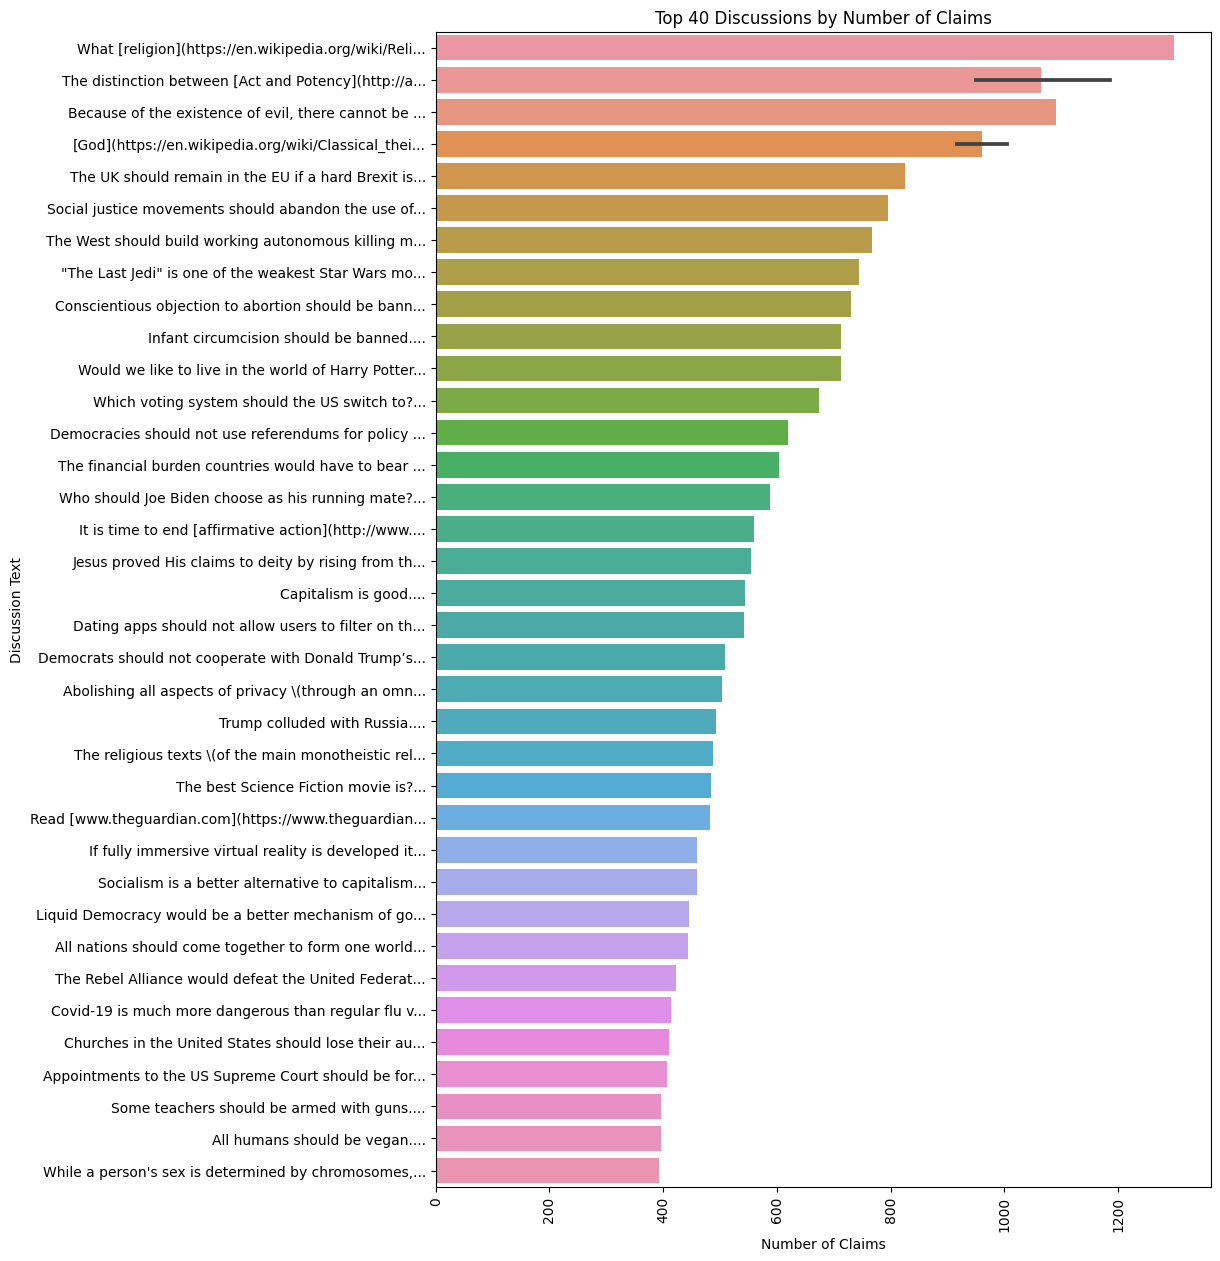

In [ ]:
# Selecting top 40 discussions based on the number of claims
top_discussions = discussion_claim_counts.nlargest(40, 'Number_of_Claims')

# Merging to get the base claim text and generating a bar plot
top_discussions_with_text = pd.merge(top_discussions, node_df[['Base_Claim_ID', 'Base_Claim_Text', 'Shortened_Base_Claim_Text']].drop_duplicates(), on='Base_Claim_ID', how='left')
plt.figure(figsize=(10, 15))
sns.barplot(data=top_discussions_with_text, y='Shortened_Base_Claim_Text', x='Number_of_Claims')
plt.title('Top 40 Discussions by Number of Claims')
plt.xlabel('Number of Claims')
plt.ylabel('Discussion Text')
plt.xticks(rotation=90)
plt.show()

filtering and calculating cosine similarity >= 0.95 for top 40 examples

# Finding Main Topics in the 100 Largest Discussions

## Using Bag Of Words (BOW)

In [ ]:
"""
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text
"""

In [ ]:
# Preprocess base claim texts by removing stop words
node_df['Processed_Base_Claim_Text'] = node_df['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))

# Create a Hashing Vectorizer model
hash_vectorizer = HashingVectorizer(n_features=5000, alternate_sign=False)
X_all_hashed = hash_vectorizer.transform(node_df['Processed_Base_Claim_Text'])

# Checking the type and shape of the hashed vector
type(X_all_hashed), X_all_hashed.shape

(scipy.sparse._csr.csr_matrix, (241659, 5000))

In [ ]:
# Text preprocessing and BoW transformation
top_discussions_with_text['Processed_Base_Claim_Text'] = top_discussions_with_text['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(top_discussions_with_text['Processed_Base_Claim_Text'])

# Computing the cosine similarity matrix
cosine_sim = cosine_similarity(X, X)

# Identifying similar discussions with similarity >= 0.95
similarity_threshold = 0.95
similar_discussions = [(top_discussions_with_text.iloc[i]['Base_Claim_ID'], top_discussions_with_text.iloc[j]['Base_Claim_ID']) for i in range(len(cosine_sim)) for j in range(i+1, len(cosine_sim)) if cosine_sim[i, j] >= similarity_threshold]

# Identifying and removing redundant discussions
redundant_disc_different_ids = set([pair[1] for pair in similar_discussions])
unique_top_discussions = top_discussions_with_text[~top_discussions_with_text['Base_Claim_ID'].isin(redundant_disc_different_ids)]

# Outputting the final list of unique top discussions
unique_top_discussions.head()

,Base_Claim_ID,Number_of_Claims,Base_Claim_Text,Shortened_Base_Claim_Text,Processed_Base_Claim_Text
0,3371.0,1298,What [religion](https://en.wikipedia.org/wiki/...,What [religion](https://en.wikipedia.org/wiki/...,religionhttpsenwikipediaorgwikireligion people...
1,53584.1,1263,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,distinction act potencyhttpaquinaswjduquetteco...
3,29870.1,1091,"Because of the existence of evil, there cannot...","Because of the existence of evil, there cannot...",existence evil cannot monotheistic god as trad...
4,2629.1,1005,[God](https://en.wikipedia.org/wiki/Classical_...,[God](https://en.wikipedia.org/wiki/Classical_...,godhttpsenwikipediaorgwikiclassical_theism exists
8,8708.1,826,The UK should remain in the EU if a hard Brexi...,The UK should remain in the EU if a hard Brexi...,uk remain eu hard brexit alternative option


In [ ]:
similar_discussions

[(53584.1, 51234.1),
 (53584.1, 2649.1),
 (53584.1, 20564.1),
 (51234.1, 2649.1),
 (51234.1, 20564.1),
 (2629.1, 43228.0),
 (2649.1, 20564.1)]

In [ ]:
import csv

fields = ['ID_Pair']

with open(base_path_gdrive+'3/redundant_discussionIDs_with_different_IDs', 'w') as f:
    write = csv.writer(f)

    write.writerow(fields)
    write.writerows(similar_discussions)

In [ ]:

def display_differences(discussion_1, discussion_2):
    """
    Identifies and returns differences between two discussions.

    Parameters:
    discussion_1 (DataFrame): DataFrame containing the first discussion.
    discussion_2 (DataFrame): DataFrame containing the second discussion.

    Returns:
    DataFrame: Columns showing differences.
    """
    differences = []
    for col in discussion_1.columns:
        if not discussion_1[col].equals(discussion_2[col]):
            diff_row = {
                'Column': col,
                'Discussion_1_Value': discussion_1[col].iloc[0] if len(discussion_1[col]) > 0 else None,
                'Discussion_2_Value': discussion_2[col].iloc[0] if len(discussion_2[col]) > 0 else None
            }
            differences.append(diff_row)
    return pd.DataFrame(differences)


In [ ]:
all_differences = []
for pair in similar_discussions:
    discussion_1 = node_df[node_df['Base_Claim_ID'] == pair[0]].reset_index(drop=True)
    discussion_2 = node_df[node_df['Base_Claim_ID'] == pair[1]].reset_index(drop=True)
    diff_df = display_differences(discussion_1, discussion_2)
    diff_df['Pair'] = f"{pair[0]} - {pair[1]}"
    all_differences.append(diff_df)


all_differences_df = pd.concat(all_differences, ignore_index=True)
all_differences_df


,Column,Discussion_1_Value,Discussion_2_Value,Pair
0,Index,212654,207341,53584.1 - 51234.1
1,Graph_Index,9797,9563,53584.1 - 51234.1
2,Node_ID,53584.11903,51234.7981,53584.1 - 51234.1
3,Depth,0,0,53584.1 - 51234.1
4,Breadth,0,0,53584.1 - 51234.1
...,...,...,...,...
86,Claim_Text,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,2649.1 - 20564.1
87,Outgoing_Node_IDs,"[2649.1573, 2649.1575, 2649.1576, 2649.1589, 2...","[20564.96, 20564.962, 20564.963, 20564.976, 20...",2649.1 - 20564.1
88,Relations_To_Outgoing,"[-1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1,...","[-1, 1, 1, -1, 1, -1, 1, -1, -1, -1, -1, 1, 1,...",2649.1 - 20564.1
89,Normalized Stance Score,-0.157895,-0.2,2649.1 - 20564.1


Verification by reading the claim text of the pairs confirms that the pairs really are redundant in their content

so by using Bag Of Words with a threshold of 95% we identified redundant base claims but not the similar base claims yet

In [ ]:
# Selecting top 100 discussions based on the number of claims
top_100_discussions = discussion_claim_counts.nlargest(100, 'Number_of_Claims')

# Merging to get the base claim text and generating a bar plot
top_100_discussions_with_text = pd.merge(top_100_discussions, node_df[['Base_Claim_ID', 'Base_Claim_Text', 'Shortened_Base_Claim_Text']].drop_duplicates(), on='Base_Claim_ID', how='left')

## Using Doc2Vec for Semantic Similarity for

In [ ]:
def inspect_similar_discussions(similarity_df, num_examples, original_df):
    """
    Function to inspect similar discussions based on their base claim texts.

    Args:
    - similarity_df: DataFrame containing similar pairs and their similarity scores.
    - num_examples: Number of examples to inspect.
    - original_df: Original DataFrame containing discussion details.

    Returns:
    None, prints the base claim texts of similar discussions.
    """
    for i, row in enumerate(similarity_df.itertuples(index=False)):
        if i >= num_examples:
            break
        id1, id2, _ = row
        text1 = original_df.loc[original_df['Base_Claim_ID'] == id1, 'Base_Claim_Text'].values[0]
        text2 = original_df.loc[original_df['Base_Claim_ID'] == id2, 'Base_Claim_Text'].values[0]

        print(f"Example {i+1}")
        print(f"ID 1: {id1}, Base Claim Text 1: {text1}")
        print(f"ID 2: {id2}, Base Claim Text 2: {text2}")
        print("----------")


In [ ]:
similarity_threshold = 0.95

In [ ]:
# Tokenize and tag the discussion texts
tagged_data = [TaggedDocument(words=word_tokenize(preprocess_text(_text).lower()), tags=[i]) for i, _text in enumerate(top_100_discussions_with_text['Base_Claim_Text'])]

# Train the Doc2Vec model
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs=100)

# Initialize empty list to store similar pairs
similar_pairs_doc2vec = []

# Find similar discussions using the trained Doc2Vec model
for i in tqdm(range(len(tagged_data))):
    test_doc_vector = model.infer_vector(tagged_data[i].words)
    similar_docs = model.docvecs.most_similar(positive=[test_doc_vector], topn=len(tagged_data))

    # Filter out discussions with similarity >= 0.95 and not the same as the test doc
    similar_filtered = [(top_100_discussions_with_text.iloc[i]['Base_Claim_ID'], top_100_discussions_with_text.iloc[sim[0]]['Base_Claim_ID'], sim[1]) for sim in similar_docs if sim[1] >= similarity_threshold and sim[0] != i]

    similar_pairs_doc2vec.extend(similar_filtered)

# Create a DataFrame from the list of similar pairs
df_similar_pairs_doc2vec = pd.DataFrame(similar_pairs_doc2vec, columns=['Base_Claim_ID_1', 'Base_Claim_ID_2', 'Doc2Vec_Similarity'])

df_similar_pairs_doc2vec.head()


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-40-c58276f3c14c>:13: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  similar_docs = model.docvecs.most_similar(positive=[test_doc_vector], topn=len(tagged_data))
100%|██████████| 100/100 [00:01<00:00, 82.34it/s]


,Base_Claim_ID_1,Base_Claim_ID_2,Doc2Vec_Similarity
0,3371.0,33660.1,0.966955
1,3371.0,38475.1,0.965638
2,3371.0,37171.0,0.961270
3,3371.0,1472.1,0.960057
4,3371.0,1414.1,0.959979


In [ ]:
df_similar_pairs_doc2vec

,Base_Claim_ID_1,Base_Claim_ID_2,Doc2Vec_Similarity
0,3371.0,33660.1000,0.966955
1,3371.0,38475.1000,0.965638
2,3371.0,37171.0000,0.961270
3,3371.0,1472.1000,0.960057
4,3371.0,1414.1000,0.959979
...,...,...,...
5350,32205.1,2415.1000,0.951287
5351,32205.1,2851.1000,0.951155
5352,32205.1,34602.1001,0.950996
5353,32205.1,13112.1000,0.950272


In [ ]:
inspect_similar_discussions(df_similar_pairs_doc2vec, num_examples=10, original_df=top_discussions_with_text)

Example 1
ID 1: 3371.0, Base Claim Text 1: What [religion](https://en.wikipedia.org/wiki/Religion) should people follow?
ID 2: 33660.1, Base Claim Text 2: Countries should have closed their borders to China to reduce the spread of [COVID-19](https://www.who.int/emergencies/diseases/novel-coronavirus-2019).
----------
Example 2
ID 1: 3371.0, Base Claim Text 1: What [religion](https://en.wikipedia.org/wiki/Religion) should people follow?
ID 2: 38475.1, Base Claim Text 2: Democrats [condemned](https://www.theguardian.com/world/2012/apr/26/democrats-gop-plot-obstruct-obama) Republicans for unwarranted obstructionism aimed at [hurting](http://www.politico.com/magazine/story/2016/12/republican-party-obstructionism-victory-trump-214498) Obama's political standing; it would be hypocritical of them to do the same now.
----------
Example 3
ID 1: 3371.0, Base Claim Text 1: What [religion](https://en.wikipedia.org/wiki/Religion) should people follow?
ID 2: 37171.0, Base Claim Text 2: The financial

In [ ]:
save(df_similar_pairs_doc2vec , "df_top_100_similar_pairs_doc2vec", 3)

**Conclusion**  

Semantic relations between discussion titles are found but it´s often unclear, what  common denominator was used. This lets many identified groupings appear far-fetched.

## Using LDA Topic Modelling

In [60]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
from gensim.models import CoherenceModel
from collections import defaultdict
from gensim.corpora import Dictionary
stop_words = set(stopwords.words('english'))

In [ ]:
top_100_discussions_with_text['Processed_Base_Claim_Text'] = top_100_discussions_with_text['Base_Claim_Text'].apply(lambda x: preprocess_text_with_stopwords(x, stop_words))

### Insights and Adjustments Based on Previous Rounds

For details on previous results see copy of this notebook in GDrive  

#### First Trial:
**Parameters:** `num_topics=6`, `passes=10`

**Insights:**
- Topic 0 primarily focused on politics with words like "campaign," "rights," and "government."
- Topic 1 seemed to discuss religion with keywords like "god," "world," and "existence."
- Topic 2 was a mix but included religious terms like "exists" and "god."
- Topic 3 revolved around social issues, featuring "sex" and "determined."
- Topic 4 was unclear but had elements of politics.
- Topic 5 also included social elements with "society" and "democracy."

#### Last Trial:
**Parameters:** `num_topics=6`, `passes=1000`

**Insights:**
- Topics became slightly clearer, but some topics still had overlaps and some were still unclear.
- Topic 5, for instance, was well-focused on religion and existence.

#### Coherence Score Analysis
The highest coherence score was for `num_topics=4`.  
    
Based on this observation the main topics were refined to (with seeds set manually based on commonly associated words):
  
1. Politics and Society: Combines aspects of governance, policy, and social issues.  
Seed Words: ['government', 'democracy', 'policy', 'society', 'rights']  
2. Religion and Ethics: Includes religious and ethical considerations.  
Seed Words: ['god', 'faith', 'moral', 'ethical', 'justice']  
3. Science and Technology: Merges scientific research with technological advancements.  
Seed Words: ['science', 'research', 'tech', 'internet', 'experiment']  
4. Culture and Lifestyle: Encompasses cultural norms, values, and everyday life.  
Seed Words: ['culture', 'values', 'lifestyle', 'custom', 'tradition']  

In [ ]:
top_100_discussions_with_text

,Base_Claim_ID,Number_of_Claims,Base_Claim_Text,Shortened_Base_Claim_Text,Processed_Base_Claim_Text,Dominant_Topic
0,3371.000,1298,What [religion](https://en.wikipedia.org/wiki/...,What [religion](https://en.wikipedia.org/wiki/...,"[religion, https, people, follow]",0
1,53584.100,1263,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,"[distinction, act, potency, http, combined, vi...",1
2,51234.100,1091,The distinction between [Act and Potency](http...,The distinction between [Act and Potency](http...,"[distinction, act, potency, http, combined, vi...",1
3,29870.100,1091,"Because of the existence of evil, there cannot...","Because of the existence of evil, there cannot...","[existence, evil, monotheistic, god, tradition...",1
4,2629.100,1005,[God](https://en.wikipedia.org/wiki/Classical_...,[God](https://en.wikipedia.org/wiki/Classical_...,"[god, https, exists]",0
...,...,...,...,...,...,...
95,29320.000,286,Who should the Conservative Party choose to be...,Who should the Conservative Party choose to be...,"[conservative, party, choose, next, uk, prime,...",2
96,31776.100,283,Creationism should be taught in schools.,Creationism should be taught in schools....,"[creationism, taught, schools]",4
97,18807.100,279,Feminism empowers both women and men.,Feminism empowers both women and men....,"[feminism, empowers, women, men]",0
98,38531.102,278,The usage of office real estate will continue ...,The usage of office real estate will continue ...,"[usage, office, real, estate, continue, declin...",2


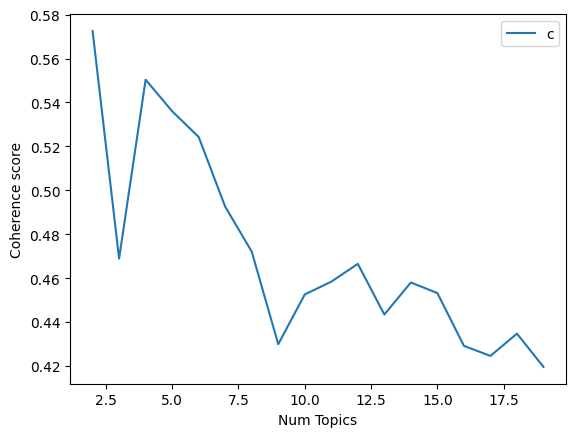

Num Topics = 2  has Coherence Value of 0.5726
Num Topics = 3  has Coherence Value of 0.4689
Num Topics = 4  has Coherence Value of 0.5503
Num Topics = 5  has Coherence Value of 0.536
Num Topics = 6  has Coherence Value of 0.5243
Num Topics = 7  has Coherence Value of 0.4925
Num Topics = 8  has Coherence Value of 0.4721
Num Topics = 9  has Coherence Value of 0.4299
Num Topics = 10  has Coherence Value of 0.4526
Num Topics = 11  has Coherence Value of 0.4584
Num Topics = 12  has Coherence Value of 0.4665
Num Topics = 13  has Coherence Value of 0.4434
Num Topics = 14  has Coherence Value of 0.458
Num Topics = 15  has Coherence Value of 0.4532
Num Topics = 16  has Coherence Value of 0.4292
Num Topics = 17  has Coherence Value of 0.4246
Num Topics = 18  has Coherence Value of 0.4347
Num Topics = 19  has Coherence Value of 0.4196
Topic 0 : Words: ['would', 'god', 'world', 'one', 'good', 'existence', 'human', 'causer', 'gender', 'government']
Topic 1 : Words: ['banned', 'god', 'us', 'sex', 'd

In [61]:
# Function to compute coherence values for finding optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Creating Dictionary and Corpus
dictionary = Dictionary(top_100_discussions_with_text['Processed_Base_Claim_Text'].apply(word_tokenize))
corpus = [dictionary.doc2bow(text.split()) for text in top_100_discussions_with_text['Processed_Base_Claim_Text']]

# LDA parameters
num_topics = 6
passes = 1000  # Increase passes to 1000


# Defining adjusted seed words for main topics
main_topics_seed_words = {
    'Politics and Society': ['government', 'democracy', 'policy', 'society', 'rights'],
    'Religion and Ethics': ['god', 'faith', 'moral', 'ethical', 'justice'],
    'Science and Technology': ['science', 'research', 'tech', 'internet', 'experiment'],
    'Culture and Lifestyle': ['culture', 'values', 'lifestyle', 'custom', 'tradition']
}

# Initializing the LDA model
lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

# Modifying the LDA model using seed words
topic_word_distrib = lda_model.get_topics()
for topic_id, seed_words in enumerate(main_topics_seed_words.values()):
    for word in seed_words:
        if word in dictionary.token2id:
            word_id = dictionary.token2id[word]
            topic_word_distrib[topic_id, word_id] *= 10
lda_model.state.get_lambda()[:] = topic_word_distrib
lda_model.sync_state()

# Computing coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=top_100_discussions_with_text['Processed_Base_Claim_Text'].apply(word_tokenize), start=2, limit=20, step=1)

# Plotting
limit = 20; start = 2; step = 1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

# Choosing the model with highest coherence value and printing the topics
optimal_model = model_list[coherence_values.index(max(coherence_values))]
model_topics = optimal_model.show_topics(formatted=False)
for idx, topic in model_topics:
    print(f'Topic {idx} : Words: {[word[0] for word in topic]}')


#### Observations

The LDA model with 4 topics and 1000 passes did not yield satisfactory results. The topics are still not as distinct as we would like them to be. The coherence value suggests 2 topics, but that's too few for our application.

#### Conclusion

Given these outcomes, it seems that LDA, even with guided topic seeding, is not sufficient to create the distinct topic clusters we desire.

#### Next Steps

Exploration of alternative methods is necessary.

# New Section

In [ ]:
save(top_100_discussions_with_text , f"df_top_100_with_topic_modelling_NumOfTopics_{num_topics}_Passes_{passes}", 3)

df_top_100_with_topic_modelling_NumOfTopics_5_Passes_15.csv saved to /content/drive/MyDrive/Can Language Models Follow Discussions?/3/
File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/3/df_top_100_with_topic_modelling_NumOfTopics_5_Passes_15.csv


TODO: Remove Redundnacies -- identify largest n examples for categories until around 40 discussions are selected as diverse as possible

In [67]:
tagged_data = [TaggedDocument(words=word_tokenize(preprocess_text_with_stopwords(text, stop_words)), tags=[str(i)]) for i, text in enumerate(node_df['Base_Claim_Text'])]

# Initialize and train Doc2Vec model
model = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Sample evaluation: Check the most similar discussions for the first 5 discussions
for i in range(5):
    inferred_vector = model.infer_vector(tagged_data[i].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=5)
    print(f"Discussion {i} is most similar to discussions {sims}")

Discussion 0 is most similar to discussions [('16', 0.9708544015884399), ('29', 0.9677069187164307), ('30', 0.9671746492385864), ('40', 0.9635615348815918), ('12', 0.9621424078941345)]
Discussion 1 is most similar to discussions [('73', 0.961760938167572), ('57', 0.9588022828102112), ('113825', 0.9575217366218567), ('187862', 0.9566367268562317), ('147148', 0.9555370211601257)]
Discussion 2 is most similar to discussions [('9489', 0.9719042181968689), ('34', 0.9669861793518066), ('132295', 0.9554800391197205), ('73055', 0.9549001455307007), ('29', 0.9548147916793823)]
Discussion 3 is most similar to discussions [('73823', 0.9696279764175415), ('73789', 0.9681976437568665), ('59', 0.9625146985054016), ('238953', 0.9614571332931519), ('44800', 0.960218071937561)]
Discussion 4 is most similar to discussions [('195800', 0.9501314759254456), ('7', 0.9430612921714783), ('223303', 0.9409130215644836), ('83372', 0.9365952014923096), ('217696', 0.9361051917076111)]


<ipython-input-67-5550fae2a3c1>:11: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  sims = model.docvecs.most_similar([inferred_vector], topn=5)


In [68]:
import pickle

# Save the model to Google Drive
with open("/content/drive/MyDrive/Can Language Models Follow Discussions?/3/doc2vec_model_v1.pkl", "wb") as f:
    pickle.dump(model, f)


In [ ]:
stop

In [ ]:
from scipy.sparse import vstack
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity_in_chunks(matrix, chunk_size=1000):
    """
    Calculate cosine similarity for a large matrix in chunks to prevent memory overflow.
    """
    n_rows = matrix.shape[0]
    similar_pairs = []

    # Loop over the matrix in chunks
    for i in tqdm(range(0, n_rows, chunk_size)):
        start = i
        end = min(i + chunk_size, n_rows)

        # Calculate cosine similarity for a chunk
        chunk_similarities = cosine_similarity(matrix[start:end], matrix)

        # Find and store similar pairs in the chunk
        for j in range(chunk_similarities.shape[0]):
            for k in range(j + 1, chunk_similarities.shape[1]):
                if j + start == k:  # Skip self-similarity
                    continue

                similarity = chunk_similarities[j, k]
                similar_pairs.append((j + start, k, similarity))

    return pd.DataFrame(similar_pairs, columns=['Base_Claim_ID_1', 'Base_Claim_ID_2', 'Similarity'])

# Assume X_all_hashed is your hashed feature matrix and node_df contains the Base_Claim_IDs
chunk_size = 1000  # You can adjust this based on your available RAM

# Calculating cosine similarity in chunks
cosine_sim_all = calculate_cosine_similarity_in_chunks(X_all_hashed, chunk_size=chunk_size)

# Saving the calculated similarities
save(cosine_sim_all, "cosine_sim_all", 3)  # Replace 'save' with your actual saving function

  0%|          | 1/242 [01:27<5:49:39, 87.05s/it]